In [1]:
import dns
import numpy as np
from pathlib import Path
from scipy import optimize as opt
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

In [2]:
Ry = True
dt = 0.02
statesdir = Path("./")
savedir = Path("./")
states = sorted(list(statesdir.glob("state.*")))

In [3]:
state_, header_ = dns.readState(states[0])
nx, ny_half, nz = state_.shape[:3]
if Ry and ny_half % 2 != 0:
    exit("Ry but ny_half is not even.")

In [4]:
if Ry:
    projections_x = np.zeros((len(states), ny_half // 2, 3, 2))
    projections_z = np.zeros((len(states), ny_half // 2, 3, 2))
else:
    projections_x = np.zeros((len(states), ny_half, 3, 2))
    projections_z = np.zeros((len(states), ny_half, 3, 2))

In [5]:
times = []
for istate in range(len(states)):
    state, header = dns.readState(states[istate])
    forcing, nx, ny, nz, Lx, Lz, Re, tilt_angle, dt, itime, time = header
    times.append(time)
    if Ry:
        # real parts
        
        # u component, only even modes
        # x template
        projections_x[istate, :, 0, 0] = np.ravel(state[1,:,0,0][::2]).real
        # z template
        projections_z[istate, :, 0, 0] = np.ravel(state[0,:,1,0][::2]).real
        
        # v component, only odd modes
        # x template
        projections_x[istate, :, 1, 0] = np.ravel(state[1,1:,0,1][::2]).real
        # z template
        projections_z[istate, :, 1, 0] = np.ravel(state[0,1:,1,1][::2]).real
        
        # w component, only even modes
        # x template
        projections_x[istate, :, 2, 0] = np.ravel(state[1,:,0,2][::2]).real
        # z template
        projections_z[istate, :, 2, 0] = np.ravel(state[0,:,1,2][::2]).real
        
        # imaginary parts

        # u component, only even modes
        # x template
        projections_x[istate, :, 0, 1] = np.ravel(state[1,:,0,0][::2]).imag
        # z template
        projections_z[istate, :, 0, 1] = np.ravel(state[0,:,1,0][::2]).imag
        
        # v component, only odd modes
        # x template
        projections_x[istate, :, 1, 1] = np.ravel(state[1,1:,0,1][::2]).imag
        # z template
        projections_z[istate, :, 1, 1] = np.ravel(state[0,1:,1,1][::2]).imag
        
        # w component, only even modes
        # x template
        projections_x[istate, :, 2, 1] = np.ravel(state[1,:,0,2][::2]).imag
        # z template
        projections_z[istate, :, 2, 1] = np.ravel(state[0,:,1,2][::2]).imag
    else:
        # real parts
        
        # x template
        projections_x[istate, :, :, 0] = np.ravel(state[1,:,0,:]).real
        # z template
        projections_z[istate, :, :, 0] = np.ravel(state[0,:,1,:]).real
        
        # imaginary parts
        
        # x template
        projections_x[istate, :, :, 1] = np.ravel(state[1,:,0,:]).imag
        # z template
        projections_z[istate, :, :, 1] = np.ravel(state[0,:,1,:]).imag

In [6]:
def find_shift(projection):
    shift = (np.arctan2(projection.imag, projection.real) / (2 * np.pi)) % 1
    return shift

def find_dphases(projections):
    shifts = find_shift(projections)
    phases = np.unwrap(shifts * 2 * np.pi)
    dphases = (phases[1:] - phases[:-1]) / dt
    return dphases

def constraint_unit_template(coeffs):
    return np.sqrt(np.sum(coeffs**2))

def maximize_average(coeffs, projs):
    res = projs @ coeffs
    abs_res = np.abs(res)
    return -np.sqrt(np.average(abs_res**2))

In [7]:
def optimal_template(projections,str_projections,verbose=1,maxiter=10000):
    
    tag = f"{str_projections}"
    print(tag)
    
    # start with all 1
    x0 = np.ones(projections.shape[-1]) / np.sqrt(projections.shape[-1])
    constraints = opt.NonlinearConstraint(constraint_unit_template,1,1)

    with tqdm(total=maxiter) as pbar:
        def bar(dummy1, dummy2):
            pbar.update(1)
        opts = opt.minimize(maximize_average,x0,args=(projections,),method="trust-constr",
                            constraints=constraints,
                            options={"verbose": verbose, "maxiter": maxiter},
                            callback=bar)
    coeffs = opts.x
    np.savetxt(f"coeffs_{tag}.gp", coeffs)

    projections_opt = projections @ coeffs
    abs_projections_opt = np.abs(projections_opt)
    shifts = find_shift(projections_opt)
    phases = np.unwrap(shifts * 2 * np.pi)
    dphases = (phases[1:] - phases[:-1]) / dt

    fig, ax = plt.subplots()
    ax.plot(times, np.abs(projections_opt))
    ax.set_xlabel("$t$")
    ax.set_ylabel(f"$|p_{str_projections}|$")
    ax.set_xlim(left=times[0], right=times[-1])
    fig.savefig(savedir / f"p{tag}.png", bbox_inches="tight")

    # Plot phases
    fig, ax = plt.subplots()
    ax.plot(times, phases)
    ax.set_xlabel("$t$")
    ax.set_ylabel(f"$\\phi_{str_projections}$")
    ax.set_xlim(left=times[0], right=times[-1])
    fig.savefig(savedir / f"phase_{tag}.png", bbox_inches="tight")

    # Plot phase derivatives
    fig, ax = plt.subplots()
    ax.plot(times[:-1], dphases)
    ax.set_xlabel("$t$")
    ax.set_ylabel(f"$\\dot{{\\phi_{str_projections}}}$")
    ax.set_xlim(left=times[0], right=times[-2])
    fig.savefig(savedir / f"dphase_{tag}.png", bbox_inches="tight")
    
    plt.show()

x


  0%|          | 0/10000 [00:00<?, ?it/s]

/home/gokhan/usr/local/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


`gtol` termination condition is satisfied.
Number of iterations: 91, function evaluations: 4500, CG iterations: 124, optimality: 9.22e-09, constraint violation: 0.00e+00, execution time: 0.21 s.


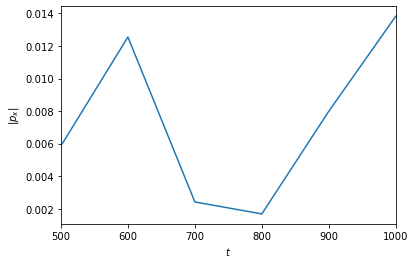

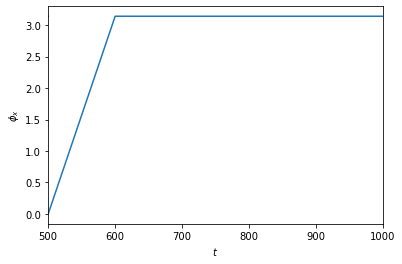

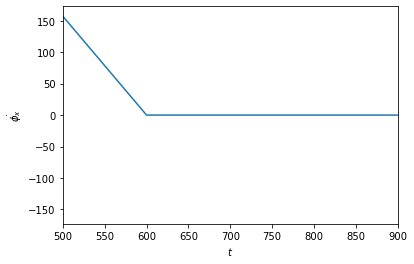

z


  0%|          | 0/10000 [00:00<?, ?it/s]

`gtol` termination condition is satisfied.
Number of iterations: 91, function evaluations: 4500, CG iterations: 124, optimality: 9.22e-09, constraint violation: 0.00e+00, execution time:  0.2 s.


/home/gokhan/usr/local/anaconda3/lib/python3.9/site-packages/scipy/optimize/_hessian_update_strategy.py:182: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  warn('delta_grad == 0.0. Check if the approximated '


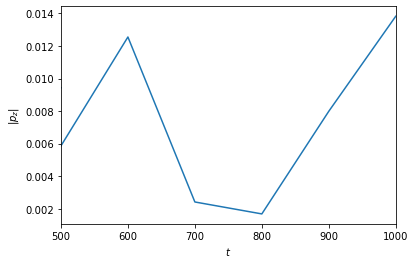

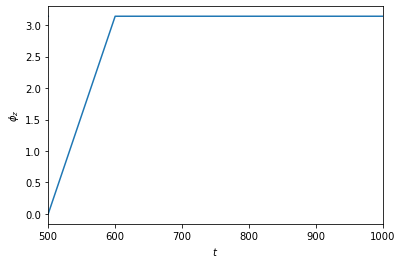

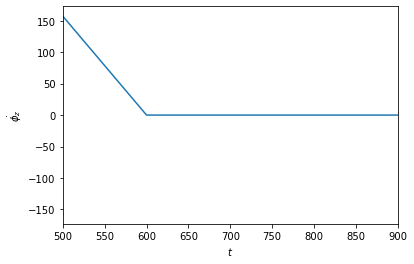

In [8]:
if Ry:
    optimal_template(np.reshape(projections_x, (len(states), ny_half*3*2//2)),"x")
    optimal_template(np.reshape(projections_x, (len(states), ny_half*3*2//2)),"z")
else:
    optimal_template(np.reshape(projections_x, (len(states), ny_half*3*2)),"x")
    optimal_template(np.reshape(projections_x, (len(states), ny_half*3*2)),"z")